# Black Scholes Model Deep Calibration - learning the implied volatility

In this notebook we train a neural network to estimate the implied volatility of an European option. For this, we first generate a dataset of synthetic dataset and use the Black Scholes formula to calculate option prices which are then used to calculate the implied volatility. In a second step we train a simple neural network to predict the implied volatility when given the stock price and the strike price of the option, the time to maturity, the risk free rate and the historical volatility. After training the model can be used to predict the implied volatility of an option given data unknown to the model.

In a first step the required libraries are imported.

In [1]:
# Libraries laden
import numpy as np
from math import log, sqrt, exp
from scipy import stats
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Data generation and preparation

In the next cell a function similar to R's expand grid is defined which is then used to generate the synthetic data. After that some functions to calculate the option price based on the Black-Scholes formula and to calculate the implied volatility are defined. Functions for the option vega and the implied volatility were taken from https://aaronschlegel.me/implied-volatility-functions-python.html.

In [2]:
# Function that equals R's expand_grid
import itertools
def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [316]:
# Generate sznthetic data
synthetic_data = expand_grid({
    'stock_price': np.arange(40, 61),
    'strike_price':np.arange(20, 90),
    'maturity': np.arange(3/12, 2, step = 1/12),
    'risk_free_rate':np.arange(0.01, 0.06, step = 0.01),
    'sigma': np.arange(0.1, 0.9, step = 0.1)
}
)

In [317]:
# Black-Scholes option value
def bs_option_value(S0, K, T, r, sigma):
    'Function to calculate the value of a call option based on the Black-Scholes formula'
    'arguments:'
    'S0: inital stock price'
    'K: strike price'
    'T: maturity'
    'r: risk free rate (constant)'
    'sigma: volatility'
    'returns: option value'
    #calculate d1 and d2
    d1 = ((np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
    d2 = ((np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
    option_value = S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0)
    return option_value

In [318]:
# Testing the function
bs_option_value(1,2,4,3,5)

0.9999999988919036

In [319]:
# calculate option vega
def option_vega(S0, K, T, r, sigma):
    'takes the same arguments as the function above'
    'returns option vega'
    d1 = ((np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T)))
    vega = S0 * stats.norm.cdf(d1, 0.0, 1.0) * np.sqrt(T)
    return vega

In [320]:
# Testing the function
option_vega(1,2,3,4,5)

1.7320507924724615

In [321]:
# calculate implied volatility
def implied_volatility(S0, K, T, C0, r, sigma):
    'calculates the implied volatility'
    'C0: call price'
    'returns implied volatility'
    d1 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    fx = S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0) - C0
    
    vega = (1 / np.sqrt(2 * np.pi)) * S0 * np.sqrt(T) * np.exp(-(stats.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    # Warum hier andere Formal fuer vega?
    
    
    tolerance = 0.000001
    x0 = sigma
    xnew  = x0
    xold = x0 - 1
        
    while (abs(xnew - xold) > tolerance):
        xold = xnew
        xnew = (xnew - fx - C0) / vega
        
        return abs(xnew)
# Source for the vega und iv functions: https://aaronschlegel.me/implied-volatility-functions-python.html

In [322]:
# Testing the function
implied_volatility(1,2,3,4,5,6)

8.683118302572918

In [323]:
synthetic_data['black_scholes'] = bs_option_value(synthetic_data['stock_price'], synthetic_data['strike_price'],
                                               synthetic_data['maturity'], synthetic_data['risk_free_rate'],
                                               synthetic_data['sigma'])

In [324]:
# Add some random noise to the prices to create the option prices
synthetic_data["option_price"] = synthetic_data["black_scholes"] + np.random.normal(1, 0.1)

In [325]:
# Calculate implied volatility (the variable of interest; used later in the neural network)
synthetic_data['imp_vol'] = synthetic_data.apply(lambda row: implied_volatility(row['option_price'], row['stock_price'], row['strike_price'],
                                              row['maturity'], row['risk_free_rate'], row['sigma']), axis = 1)

In [326]:
synthetic_data.tail()

,stock_price,strike_price,maturity,risk_free_rate,sigma,black_scholes,option_price,imp_vol
1234795,60,89,1.916667,0.05,0.4,7.034793,8.180721,0.013399
1234796,60,89,1.916667,0.05,0.5,10.297248,11.443176,0.001966
1234797,60,89,1.916667,0.05,0.6,13.608121,14.754049,0.008033
1234798,60,89,1.916667,0.05,0.7,16.897179,18.043107,0.009676
1234799,60,89,1.916667,0.05,0.8,20.122101,21.268029,0.009879


The final dataset contains 1234799 observations of the generated stock and strike prices (in dollar), the time to maturity (as fractions of a year), the risk free rate (as percentage), the realised volatility, the (black scholes) option price (in dollar) and the implied volatility. 

In [327]:
# generate train and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(synthetic_data, test_size = 0.01,
                                                   random_state = 42)

In [332]:
# Dataframes with Xs and ys
X_train = train.drop(['option_price', 'imp_vol', 'black_scholes'], axis = 1)
X_test = test.drop(['option_price', 'imp_vol', 'black_scholes'], axis = 1)
y_train = train['imp_vol']
y_test = test['imp_vol']

In [333]:
X_train

,stock_price,strike_price,maturity,risk_free_rate,sigma
483303,48,35,0.833333,0.03,0.8
992823,56,81,1.833333,0.03,0.8
523674,48,83,0.916667,0.05,0.3
456675,47,73,1.333333,0.05,0.4
160003,42,70,1.083333,0.01,0.4
...,...,...,...,...,...
110268,41,81,0.666667,0.04,0.5
259178,44,48,1.166667,0.03,0.3
131932,42,37,0.333333,0.02,0.5
671155,51,48,1.916667,0.05,0.4


In [334]:
X_train.shape

(1222452, 5)

## Model generation

In [335]:
# Build the neural network
from keras.layers import Activation
model = tf.keras.models.Sequential([
    #tf.keras.layers.InputLayer(input_shape = (5,)), # Anzahl Features
    tf.keras.layers.Dense(units = 200, activation = 'relu', input_shape = (5,)),
    #tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 200, activation = 'relu'),
    #tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 200, activation = 'relu'),
    #tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 200, activation = 'relu'),
    #tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 1, activation = 'linear')
])
model.compile(loss='mse',optimizer='adam')
# Model configuration: The model architecture was chosen based on a literature review (e.g. Liu et al. (2019)).

In [336]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 200)               1200      
_________________________________________________________________
dense_58 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_59 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_60 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________


In [337]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=4) 

# https://blog.paperspace.com/tensorflow-callbacks/

The model architecture was chosen based on a literature review. It is common to use a small number of hidden layers (about 5). Dropdown layers can be used but in our case did not improve the model. A callback was implemented to stop training once a certain number of epochs did not improve the loss.

## Model training

In [338]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.1, batch_size = 1024, epochs = 1000, verbose = 1, callbacks = [callback])

Epoch 1/1000
1075/1075 [==============================] - 27s 25ms/step - loss: 0.0290 - val_loss: 9.2186e-04
Epoch 2/1000
1075/1075 [==============================] - 25s 23ms/step - loss: 9.0966e-04 - val_loss: 8.3540e-04
Epoch 3/1000
1075/1075 [==============================] - 25s 24ms/step - loss: 0.0010 - val_loss: 8.3192e-04
Epoch 4/1000
1075/1075 [==============================] - 26s 24ms/step - loss: 9.3901e-04 - val_loss: 7.5373e-04
Epoch 5/1000
1075/1075 [==============================] - 25s 23ms/step - loss: 8.6927e-04 - val_loss: 7.2543e-04
Epoch 6/1000
1075/1075 [==============================] - 24s 23ms/step - loss: 6.9351e-04 - val_loss: 6.8770e-04
Epoch 7/1000
1075/1075 [==============================] - 25s 23ms/step - loss: 0.0022 - val_loss: 9.7058e-04
Epoch 8/1000
1075/1075 [==============================] - 24s 23ms/step - loss: 8.8909e-04 - val_loss: 7.8476e-04 ETA: 0s - loss: 8.8909e-0
Epoch 9/1000
1075/1075 [==============================] - 25s 23ms/step - 

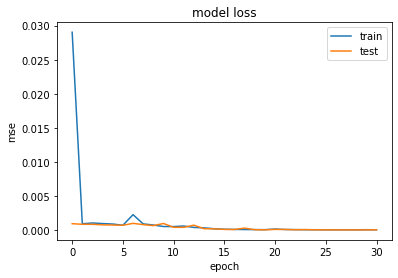

In [366]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Training stopped after 31 epochs. Training loss dropped sharply during the first epochs and after that declined only slightly.

## Model evaluation and predictions on the test set

In [367]:
# Generate predictions on the test set
y_hat = model.predict(X_test)
y_hat = np.squeeze(y_hat)

In [368]:
y_hat = np.array(y_hat, dtype='float')

In [374]:
# Define a function to calculate some performance measures
def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = np.mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = np.sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = np.mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = np.sqrt(stats['mse'])/np.mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    plt.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(10,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual IV',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted IV',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    return stats
# Source: https://srdas.github.io/DLBook/DeepLearningWithPython.html#option-pricing

Mean Squared Error:       2.6063544273514026e-05
Root Mean Squared Error:  0.0051052467397290436
Mean Absolute Error:      0.002930120523583702
Mean Percent Error:       0.13929870125486432


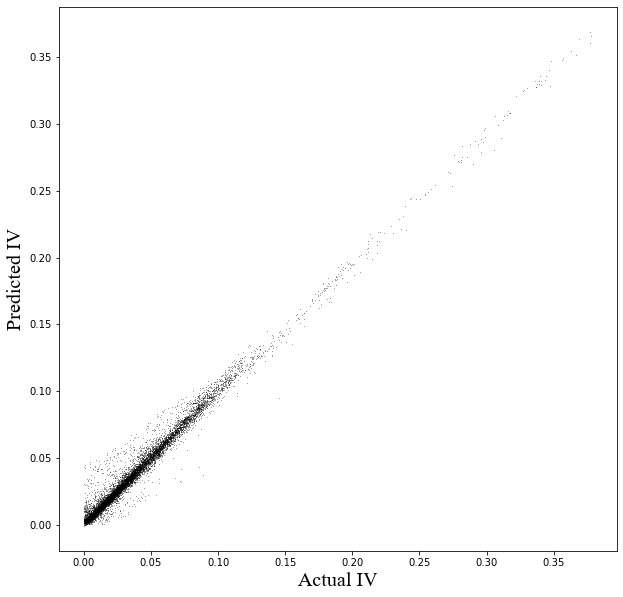

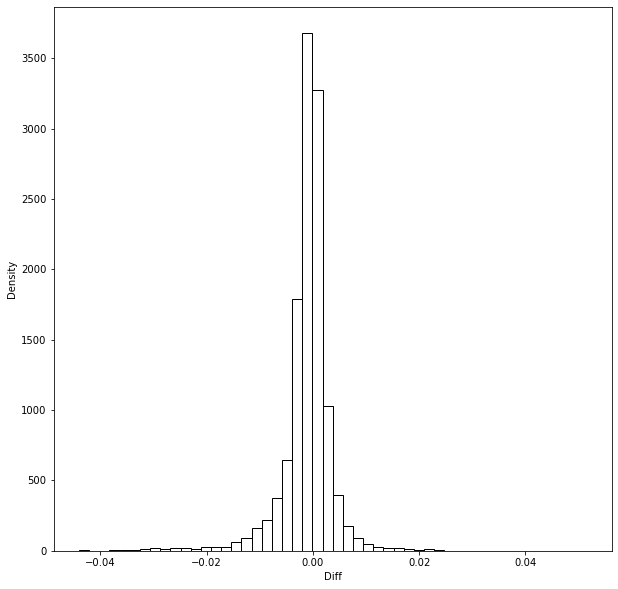

{'diff': 954765     0.000242
 711377     0.002982
 1086810    0.002154
 859684    -0.002975
 1040050   -0.002955
              ...   
 530703     0.002041
 608920    -0.002459
 591292    -0.003862
 462411    -0.001473
 1120191   -0.000852
 Name: imp_vol, Length: 12348, dtype: float64,
 'mse': 2.6063544273514026e-05,
 'rmse': 0.0051052467397290436,
 'mae': 0.002930120523583702,
 'mpe': 0.13929870125486432}

In [375]:
# Print performance measures and plot actual versus predicted iv
CheckAccuracy(y_test,y_hat)

Overall the model performed quite well with a mean percentage error of 0.14. 

In the next step a small test dataframe is created to plot the implied volatility surface. If real data were available the folliwng part could be used to test the model on real data and plot the implied volatility. The formula to plot the implied volatility surface was taken from https://github.com/svenhsia/Calibrating-Rough-Volatility-Models-with-Deep-Learning/blob/master/Deep-Calibration.ipynb.

In [349]:
# Define a function that plots the implied volatility surface
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

def plot_iv_surface(data, x="moneyness", y='maturity', z='iv'):
    """ Plots the IV surface
    """
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection='3d')
    ax.azim = 120
    ax.elev = 13
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

    ax.invert_xaxis()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    
    surf = ax.plot_trisurf(data[x], data[y], data[z], antialiased=True, cmap = plt.cm.Spectral)
    fig.colorbar(surf, shrink=0.7, aspect=10)
    
    plt.tight_layout()
    
    plt.show()
# Source: https://github.com/svenhsia/Calibrating-Rough-Volatility-Models-with-Deep-Learning/blob/master/Deep-Calibration.ipynb

In [352]:
# Plot iv for new data (i.e. use the model on real data)
stock_price = np.linspace(40, 60, 21)
strike_price = np.linspace(20,90, 21)
maturity = np.linspace(3/12, 2, 21)

stock_price, strike_price, maturity = np.meshgrid(stock_price, strike_price, maturity)

df_iv = pd.DataFrame(columns=train.columns)
df_iv['stock_price'] = stock_price.flatten()
df_iv['strike_price'] = strike_price.flatten()
df_iv['maturity'] = maturity.flatten()
df_iv['risk_free_rate'] = 0.01
df_iv['sigma'] = 0.1

In [354]:
# Calculate option prices using the Black Scholes formula
df_iv['black_scholes'] = bs_option_value(df_iv['stock_price'], df_iv['strike_price'],
                                               df_iv['maturity'], df_iv['risk_free_rate'],
                                               df_iv['sigma'])

In [355]:
# Add some random noise to the real prices to create the option prices
df_iv["option_price"] = df_iv["black_scholes"] + np.random.normal(1, 0.1)

In [356]:
# Calculate the implied volatility
df_iv['imp_vol'] = df_iv.apply(lambda row: implied_volatility(row['option_price'], row['stock_price'], row['strike_price'],
                                              row['maturity'], row['risk_free_rate'], row['sigma']), axis = 1)

In [357]:
df_iv_2 = df_iv.drop(['black_scholes', 'option_price', 'imp_vol'], axis = 1)

In [360]:
df_iv['iv_pred'] = model.predict(df_iv_2)

In [361]:
df_iv['moneyness'] = df_iv['strike_price'] / df_iv['stock_price']

In [362]:
df_iv['mae'] = abs(df_iv['imp_vol'] - df_iv['iv_pred'])

In [363]:
df_iv

,stock_price,strike_price,maturity,risk_free_rate,sigma,black_scholes,option_price,imp_vol,iv_pred,moneyness,mae
0,40.0,20.0,0.2500,0.01,0.1,20.049938,21.069326,0.038066,0.038913,0.5,0.000847
1,40.0,20.0,0.3375,0.01,0.1,20.067386,21.086775,0.038095,0.038788,0.5,0.000693
2,40.0,20.0,0.4250,0.01,0.1,20.084820,21.104208,0.038123,0.038662,0.5,0.000539
3,40.0,20.0,0.5125,0.01,0.1,20.102238,21.121626,0.038150,0.038536,0.5,0.000386
4,40.0,20.0,0.6000,0.01,0.1,20.119641,21.139029,0.038178,0.038520,0.5,0.000343
...,...,...,...,...,...,...,...,...,...,...,...
9256,60.0,90.0,1.6500,0.01,0.1,0.003233,1.022621,0.026244,0.020849,1.5,0.005395
9257,60.0,90.0,1.7375,0.01,0.1,0.004454,1.023843,0.026215,0.021253,1.5,0.004962
9258,60.0,90.0,1.8250,0.01,0.1,0.005970,1.025358,0.026179,0.021550,1.5,0.004629
9259,60.0,90.0,1.9125,0.01,0.1,0.007810,1.027199,0.026135,0.021839,1.5,0.004296


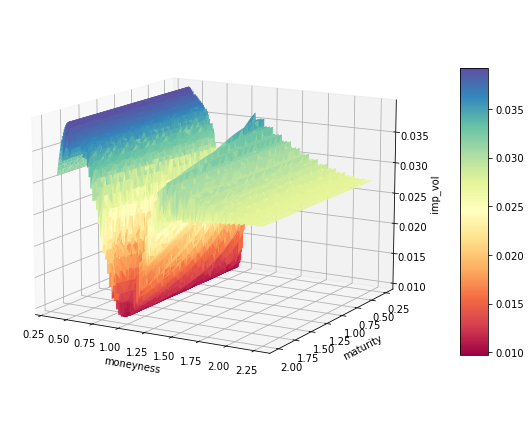

In [364]:
# Plot the implied volatility surface ("real" data)
plot_iv_surface(df_iv, z = 'imp_vol')

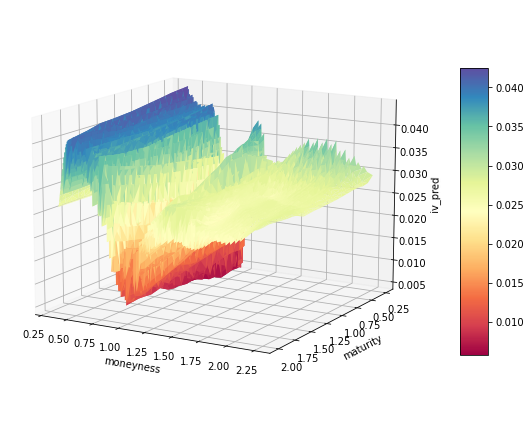

In [365]:
# PLot the implied volatility surface using the predicted implied volatility
plot_iv_surface(df_iv, z = 'iv_pred')

The implied volatility surface shows the characteristic volatility smile, i.e. the volatility is lowest when moneyness is about 1.0 and increased as moneyness becomes different from 1. The predicted volatility surface is quite similar to the actual implied volatility surface if moneyness is in the range of 0.75 to 1.25.

## Outlook
In this notebook we used the Black Scholes formula to generate synthetic data and trained a model to predict the implied volatility. Our first results look promising but leave room for further improvement. Firstly, given the lack of a dataset of historical prices large enough to train a neural network, we used synthetic data. Although this is not uncommon, instead of creating a dataset by simply generating rows of parameter combinations, simulation methods could be used to generate option prices. Secondly, for ease of demonstration, we used the Black-Scholes model, which is a rather simple financial model. Future work could also use more complex financial models such as the Heston-Model to generate option prices. Thirdly, one could also use the predicted implied volatilty to build a hedging strategy. 

## References
We found the follwing books, papers, blogposts, code and notebooks helpful during our work on the project:
 - [Statistics of Financial Markets](https://link.springer.com/book/10.1007/978-3-540-76272-0) as an introducery textbook
 - The ebook [Deep Learning with Python](https://srdas.github.io/DLBook/DeepLearningWithPython.html#option-pricing) by  and has a chapter on using deep learning for option pricing. We took the code that implements the function used to calculate several performance measures and plot the results from this source
 - [Ruf and Wang's literature review](https://arxiv.org/abs/1911.05620) on the use of deep learning for option pricing and hedging 
 - The paper [A neural network-based framework for financial model calibration](https://arxiv.org/abs/1904.10523) provides a good explanation of the used framework without relying on too much financial mathematics
 - Aaron Schlegel has a [blogpost](https://aaronschlegel.me/black-scholes-formula-python.html) which shows how to implement the Black Scholes formula in Python from which we took the functions to calculate the option vega and the implied volatility
 - Notebooks and repositories which show more sophisticated implementations of deep learning for model calibration and option pricing are for example
     - Josef Teichmann's lecture materials for his Machine Learning in Finance course can be found [here](https://people.math.ethz.ch/~jteichma/index.php?content=teach_mlf2022), [here](https://gist.github.com/jteichma/241244299bd43d1fb031527703839712), and [here](https://gist.github.com/jteichma/4d9c0079dbf4e9c3cdff3fd1befabd23)
     - The github repository [Calibrating rough volatility models with deep learning](https://github.com/svenhsia/Calibrating-Rough-Volatility-Models-with-Deep-Learning) by user svenhsia from which the function to plot the implied volatility surface was taken
     - Andres Hernandez who was one of the first to propose the use of neural networks for model calibration also provides a [repository](https://github.com/Andres-Hernandez/CalibrationNN) with code related to his [paper]()
     - Horvard, Muguruza and Tomas also have a [repository](https://github.com/amuguruza/NN-StochVol-Calibrations) with code related to their [paper on learning volatility](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3322085)
     -[This repository](https://github.com/cantaro86/Financial-Models-Numerical-Methods) contains a selection of notebooks on different topics in the area of quantitative finance